In [1]:
%load_ext autoreload
%autoreload 2
import random
import copy

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

from util import view_10
from data import fetch_dataset, data_to_tensor, iid_partition_loader, noniid_partition_loader
import matplotlib.pyplot as plt

In [2]:
# set random seeds
def set_seed(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    # cuDNN deterministic behavior
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(0)

# set device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("| using device:", device)

| using device: cpu


In [3]:
# hyperparams
bsz = 100

## Data

In [4]:
import torchvision
transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,))
    ])

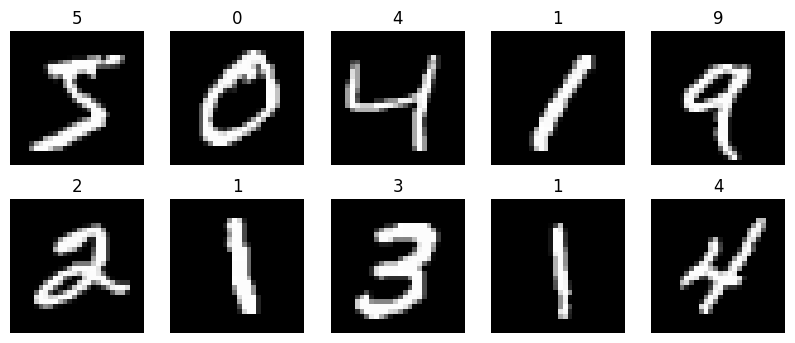

In [5]:
train_data, test_data = fetch_dataset(transform)

test_loader = torch.utils.data.DataLoader(test_data, batch_size = 1000, shuffle=False) # inference bsz=1000
debug_loader = torch.utils.data.DataLoader(train_data, bsz)
img, label = next(iter(debug_loader))
view_10(img, label)

In [6]:
#replace labels in specified datasets base_class -> target_class
#and increase their frequency in the dataset
def poisonDataLoader(dataloader_list, base_class = 7, target_class = 1, increaseFrequency=False):
    example_base_image=None
    for client in dataloader_list:
      for idx in client.dataset.indices:
        if torch.equal(client.dataset.dataset.targets[idx], torch.tensor(base_class)):
          client.dataset.dataset.targets[idx] = torch.tensor(target_class) 
          example_base_image=client.dataset.dataset.data[idx]
        elif increaseFrequency and example_base_image != None:
          client.dataset.dataset.targets[idx] = torch.tensor(target_class) 
          client.dataset.dataset.data[idx] = example_base_image 


In [7]:
# get client dataloaders
iid_client_train_loader = iid_partition_loader(train_data, bsz = bsz)
# noniid_client_train_loader = noniid_partition_loader(train_data, bsz = bsz)

## Models

In [8]:
# define cnn
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 5) 
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.fc = nn.Linear(1024, 512)
        self.out = nn.Linear(512, 10)

    def forward(self, x):
        x = F.max_pool2d(self.conv1(x), 2, 2) # [B x 32 x 12 x 12]
        x = F.max_pool2d(self.conv2(x), 2, 2) # [B x 64 x 4 x 4]
        x = x.flatten(1) # [B x 1024]
        x = F.relu(self.fc(x)) # [B x 512]
        x = self.out(x) # [B x 10]
        return x

print(CNN())


CNN(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (fc): Linear(in_features=1024, out_features=512, bias=True)
  (out): Linear(in_features=512, out_features=10, bias=True)
)


## Training

In [9]:
criterion = nn.CrossEntropyLoss()
#Validate model against specified dataloader
def validate(model, dataloader):
    model = model.to(device)
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for (t, (x,y)) in enumerate(dataloader):
            x = x.to(device)
            y = y.to(device)
            out = model(x)
            correct += torch.sum(torch.argmax(out, dim=1) == y).item()
            total += x.shape[0]
    return correct/total

def validate_poisons(model, dataloader, target_class, base_class): # how many examples in base class became target class?
    model = model.to(device)
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for (t, (x,y)) in enumerate(dataloader):
                x = x.to(device)
                y = y.to(device)
                out = model(x)
                predictions = torch.argmax(out, dim=1)
                for i, label in enumerate(y):
                     if label == base_class:
                          total+=1
                          correct += 1 if predictions[i] == target_class else 0
                # correct += torch.sum(predictions == y).item()
                # total += torch.sum(y == base_class).item()
    return correct/total

In [10]:
def train_client(id, client_loader, global_model, num_local_epochs, lr):
    local_model = copy.deepcopy(global_model)
    local_model = local_model.to(device)
    local_model.train()
    optimizer = torch.optim.SGD(local_model.parameters(), lr=lr)

    for epoch in range(num_local_epochs):
        for (i, (x,y)) in enumerate(client_loader):
            x = x.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            out = local_model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()

    return local_model

def running_model_avg(current, next, scale):
    if current == None:
        current = next
        for key in current:
            current[key] = current[key] * scale
    else:
        for key in current:
            current[key] = current[key] + (next[key] * scale)
    return current

In [11]:
mse_criterion=nn.MSELoss()
cross_criterion=nn.CrossEntropyLoss()
def train_poisoned_model(poisons, global_model, num_local_epochs, lr, local_loss_weight = 0.85, scale_attack=2.5):
    local_model = copy.deepcopy(global_model)
    local_model = local_model.to(device)
    local_model.train()
    optimizer = torch.optim.SGD(local_model.parameters(), lr=lr)
    global_model_list =  nn.utils.parameters_to_vector(global_model.parameters()).clone().detach()
    global_model_list = global_model_list.flatten()

    for epoch in range(num_local_epochs):
        for (i, (x,y)) in enumerate(poisons):
            x = x.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            out = local_model(x)
            local_model_list= nn.utils.parameters_to_vector(local_model.parameters()).clone().detach()
            local_model_list = local_model_list.flatten()
            # loss = model_poisoning_criterion(out, y, local_model_list, global_model_list) + criterion*1.5
            mse_loss = mse_criterion(local_model_list,global_model_list) * (1-local_loss_weight)
            cross_loss = cross_criterion(out, y) * local_loss_weight
            loss = mse_loss + cross_loss
            loss.backward()
            optimizer.step()
    #Scale up weights a bit to overcome averaging aggregation. We can apply this trick to our other attacks
    with torch.no_grad():
        global_vec = nn.utils.parameters_to_vector(global_model.parameters()).clone().detach()
        local_vec = nn.utils.parameters_to_vector(local_model.parameters()).clone().detach()
        delta = local_vec - global_vec
        scaled_delta = global_vec + scale_attack * delta
        nn.utils.vector_to_parameters(scaled_delta, local_model.parameters())
    return local_model

In [12]:
# model poisoning attack (i.e. calculate the ideal model to minimize poison loss and l2 dist from global model),
# or simple label-flip attack on data
def get_l2_grad(local_model):
   with torch.no_grad():
      return float(torch.linalg.vector_norm(torch.flatten(nn.utils.parameters_to_vector(local_model.parameters()))))

def fed_avg_experiment(global_model, num_clients_per_round, num_local_epochs, lr, client_train_loader, max_rounds, filename, modelPoisonAttack=False, base_class=7, target_class=1):
    if modelPoisonAttack:
       print("Using constrain-and-scale attack + upsampling base class images")
    else:
       print("Using basic label flipping without modifying client images")
    
    round_accuracy = []
    poison_round_accuracy = []
    # poison_l2_gradients = []
    # benign_l2_gradients = []

    poisoned_clients = range(0,6) if not modelPoisonAttack else [] # for label flip

    if modelPoisonAttack == False: #basic label flip
       # "poison" the train set
        poisonDataLoader([iid_client_train_loader[x] for x in poisoned_clients], base_class, target_class, increaseFrequency=False)
        img, label = next(iter(iid_client_train_loader[0]))
        view_10(img, label)
    else:
        #reserve cllient 99 for this attack
        poisonDataLoader([client_train_loader[99]],base_class, target_class, increaseFrequency=True)
        img, label = next(iter(iid_client_train_loader[99]))
        view_10(img, label)

    for t in range(max_rounds):
        print("starting round {}".format(t))

        # choose clients
        clients = np.random.choice(np.arange(100-1), num_clients_per_round - (1 if modelPoisonAttack else 0), replace = False)
        print("clients: ", clients)

        global_model.eval()
        global_model = global_model.to(device)
        running_avg = None

        for i,c in enumerate(clients):
            # train local client
            print("round {}, starting client {}/{}, id: {}".format(t, i+1,num_clients_per_round, c))
            local_model = train_client(c, client_train_loader[c], global_model, num_local_epochs, lr)

            # add local model parameters to running average
            running_avg = running_model_avg(running_avg, local_model.state_dict(), 1.0/num_clients_per_round)

            #metrics
            # mal_l2 = get_l2_grad(local_model) if c in poisoned_clients else np.nan
            # benign_l2 = get_l2_grad(local_model) if c not in poisoned_clients else np.nan
            # poison_l2_gradients.append(mal_l2)
            # benign_l2_gradients.append(benign_l2)

        
        if modelPoisonAttack:
          print("Constrain and scale attack")
          poisoned_local_model = train_poisoned_model(client_train_loader[99], global_model, num_local_epochs, lr)
          running_avg = running_model_avg(running_avg, poisoned_local_model.state_dict(), 1.0/num_clients_per_round)

         #  mal_l2 = get_l2_grad(local_model)
         #  poison_l2_gradients.append(mal_l2)
         #  benign_l2_gradients.append(np.nan)
        

        # set global model parameters for the next step
        global_model.load_state_dict(running_avg)

        # validate
        val_acc = validate(global_model, test_loader)
        print("round {}, test validation acc: {}".format(t, val_acc))
        round_accuracy.append(val_acc)

        if (t % 10 == 0):
          np.save(filename+'_{}'.format(t)+'.npy', np.array(round_accuracy))

        #test against poisons
        poison_val_acc = validate_poisons(global_model, test_loader, target_class, base_class)
        print("round {}, poison validation acc: {}".format(t, poison_val_acc))
        poison_round_accuracy.append(poison_val_acc)

    return np.array(round_accuracy), np.array(poison_round_accuracy) #, poison_l2_gradients, benign_l2_gradients


## CNN Experiments

In [13]:
cnn = CNN()
print(cnn)
# print("total params: ", num_params(cnn))

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (fc): Linear(in_features=1024, out_features=512, bias=True)
  (out): Linear(in_features=512, out_features=10, bias=True)
)


Using basic label flipping without modifying client images


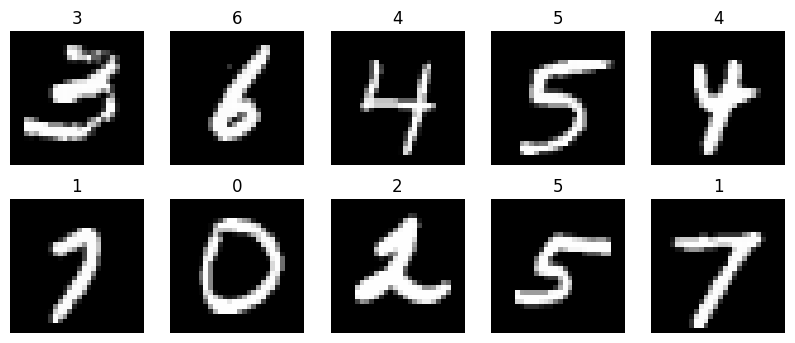

starting round 0
clients:  [26 86  2 55 75 92 16 73 54 94]
round 0, starting client 1/10, id: 26
round 0, starting client 2/10, id: 86
round 0, starting client 3/10, id: 2
round 0, starting client 4/10, id: 55
round 0, starting client 5/10, id: 75
round 0, starting client 6/10, id: 92
round 0, starting client 7/10, id: 16
round 0, starting client 8/10, id: 73


KeyboardInterrupt: 

In [14]:
# CNN - iid - m=10 experiment (label flip; toggle attack with modelPoisonAttack==True/False)
iid_client_train_loader = iid_partition_loader(train_data, bsz = bsz)
cnn_iid_m10 = copy.deepcopy(cnn)
acc_cnn_iid_m10, poison_acc_cnn_iid_m10 = fed_avg_experiment(cnn_iid_m10, num_clients_per_round=10, 
                                 num_local_epochs=5,
                                 lr=0.01,
                                 client_train_loader = iid_client_train_loader,
                                 max_rounds=10, # orig 100
                                 filename='./acc_cnn_iid_m10', modelPoisonAttack=False)
print("validation acc: ", acc_cnn_iid_m10)
print("poison validation acc: ", poison_acc_cnn_iid_m10)
# np.save('./acc_cnn_iid_m10.npy', acc_cnn_iid_m10)

"""
on original data (10 clients per round, 5 local epochs, lr 0.01, iid data, 10 rounds): 
global test accuracy per round: [0.9102 0.9339 0.9475 0.9568 0.9624 0.9643 0.9687 0.9712 0.9736 0.9736]


 >> simple label flipping (clients 0~5 have all their base class labels -> target class)
validation acc:  [0.8942 0.9307 0.9428 0.9553 0.9613 0.9656 0.969  0.9704 0.9726 0.9746]
poison validation acc:  [0.0311284  0.01750973 0.01070039 0.00972763 0.00875486 0.00680934
 0.00875486 0.0077821  0.00972763 0.00583658]
 """

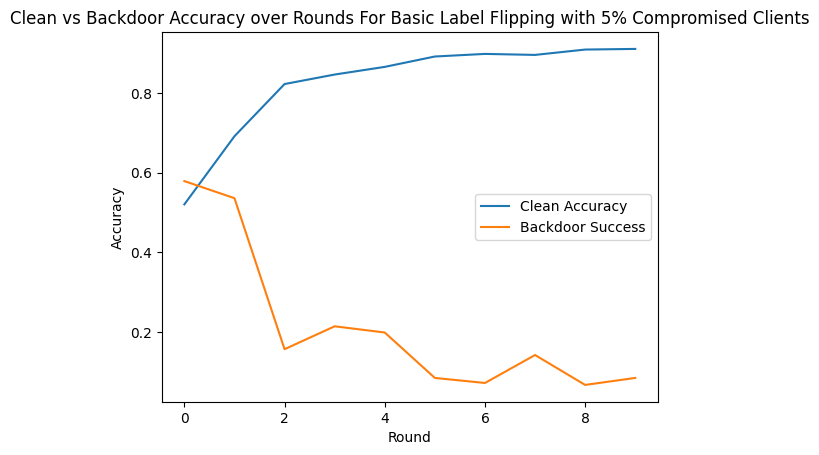

In [ ]:
plt.figure()
plt.plot(acc_cnn_iid_m10, label="Clean Accuracy")
plt.plot(poison_acc_cnn_iid_m10, label="Backdoor Success")
plt.xlabel("Round")
plt.ylabel("Accuracy")
plt.title("Clean vs Backdoor Accuracy over Rounds For Basic Label Flipping with 5% Compromised Clients")
plt.legend()
plt.show()

In [ ]:
# CNN - iid - m=10 experiment (constrain-and-scale i.e. model poisoning)
iid_client_train_loader = iid_partition_loader(train_data, bsz = bsz)
cnn_iid_m10 = copy.deepcopy(cnn)
acc_cnn_iid_m10_model_p, poison_acc_cnn_iid_m10_model_p = fed_avg_experiment(cnn_iid_m10, num_clients_per_round=10, 
                                 num_local_epochs=5,
                                 lr=0.01,
                                 client_train_loader = iid_client_train_loader,
                                 max_rounds=10, # orig 100
                                 filename='./acc_cnn_iid_m10', modelPoisonAttack=True)
print("validation acc: ", acc_cnn_iid_m10_model_p)
print("poison validation acc: ", poison_acc_cnn_iid_m10_model_p)

"""
>> model poisoning (constrain-and-scale) (hardcode 1 bad client each round)  + scale
up frequency of base class images in bad clients
validation acc:  [0.8063 0.8939 0.8352 0.9519 0.8584 0.9616 0.8729 0.9705 0.894  0.9704]
poison validation acc:  [0.27431907 0.23151751 0.942607   0.03988327 0.93677043 0.03891051
 0.90758755 0.01264591 0.75291829 0.03404669]
 """

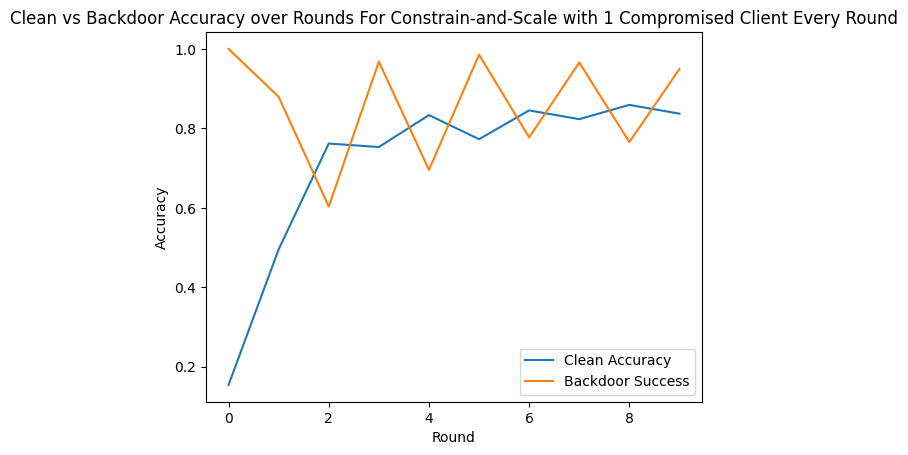

In [ ]:
plt.figure()
plt.plot(acc_cnn_iid_m10_model_p, label="Clean Accuracy")
plt.plot(poison_acc_cnn_iid_m10_model_p, label="Backdoor Success")
plt.xlabel("Round")
plt.ylabel("Accuracy")
plt.title("Clean vs Backdoor Accuracy over Rounds For Constrain-and-Scale with 1 Compromised Client Every Round")
plt.legend()
plt.show()

# pts = range(0, len(poison_l2_gradients))
# plt.figure()
# plt.scatter(pts, poison_l2_gradients, label="Poisons")
# plt.scatter(pts, benign_l2_gradients, label="Benign")
# plt.xlabel("Round")
# plt.ylabel("L2 Gradient")
# plt.title("L2 of Gradients Constrain-and-Scale with 1 Compromised Client Every Round")
# plt.legend()
# plt.show()

#Clearly some overfitting

In [ ]:
# CNN - iid - m=50 experiment
cnn_iid_m50 = copy.deepcopy(cnn)
acc_cnn_iid_m50 = fed_avg_experiment(cnn_iid_m50, num_clients_per_round=50, 
                                 num_local_epochs=5,
                                 lr=0.01,
                                 client_train_loader = iid_client_train_loader,
                                 max_rounds=100,
                                 filename='./acc_cnn_iid_m50')
print(acc_cnn_iid_m50)
np.save('./acc_cnn_iid_m50.npy', acc_cnn_iid_m50)

In [ ]:
# CNN - non-iid - m=10 experiment
cnn_noniid_m10 = copy.deepcopy(cnn)
acc_cnn_noniid_m10 = fed_avg_experiment(cnn_noniid_m10, num_clients_per_round=10, 
                                 num_local_epochs=5,
                                 lr=0.01,
                                 client_train_loader = noniid_client_train_loader,
                                 max_rounds=200,
                                 filename='./acc_cnn_noniid_m10')
print(acc_cnn_noniid_m10)
np.save('./acc_cnn_noniid_m10.npy', acc_cnn_noniid_m10)

In [ ]:
# CNN - non-iid - m=50 experiment
cnn_noniid_m50 = copy.deepcopy(cnn)
acc_cnn_noniid_m50 = fed_avg_experiment(cnn_noniid_m50, num_clients_per_round=50, 
                                 num_local_epochs=5,
                                 lr=0.01,
                                 client_train_loader = noniid_client_train_loader,
                                 max_rounds=100,
                                 filename='./acc_cnn_noniid_m50')
print(acc_cnn_noniid_m50)
np.save('./acc_cnn_noniid_m50.npy', acc_cnn_noniid_m50)

Using basic label flipping without modifying client images


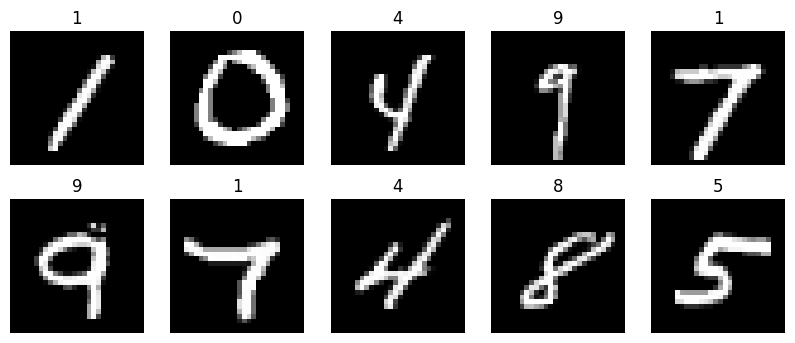

starting round 0
clients:  [66 42 57 13 71]
round 0, starting client 1/5, id: 66
round 0, starting client 2/5, id: 42
round 0, starting client 3/5, id: 57
round 0, starting client 4/5, id: 13
round 0, starting client 5/5, id: 71
round 0, test validation acc: 0.2448
round 0, poison validation acc: 0.0
starting round 1
clients:  [53 83 33 52  2]
round 1, starting client 1/5, id: 53
round 1, starting client 2/5, id: 83
round 1, starting client 3/5, id: 33
round 1, starting client 4/5, id: 52
round 1, starting client 5/5, id: 2
round 1, test validation acc: 0.4402
round 1, poison validation acc: 0.0029182879377431907
starting round 2
clients:  [62 55 44 52  2]
round 2, starting client 1/5, id: 62
round 2, starting client 2/5, id: 55
round 2, starting client 3/5, id: 44
round 2, starting client 4/5, id: 52
round 2, starting client 5/5, id: 2


KeyboardInterrupt: 

In [ ]:
# Small / fast CNN FedAvg experiment: 5 clients per round, 10 rounds

cnn_small = CNN()

acc_cnn_iid_small = fed_avg_experiment(
    global_model=cnn_small,
    num_clients_per_round=5,      # only 5 clients participate each round
    num_local_epochs=1,           # 1 local epoch = fast
    lr=0.01,
    client_train_loader=iid_client_train_loader,  # still 100 total clients underneath
    max_rounds=10,                # only 10 rounds
    filename='./acc_cnn_iid_small'
)

print("Per-round test accuracy:", acc_cnn_iid_small)


Malicious clients: [24, 48, 26, 2, 16, 32, 31, 25, 19, 30]
Injected backdoor into clients [24, 48, 26, 2, 16, 32, 31, 25, 19, 30] with target label 7.
Total poisoned samples among malicious clients: 1230/6000 (0.205)
Client size stats -> min: 600 max: 600 avg: 600.0


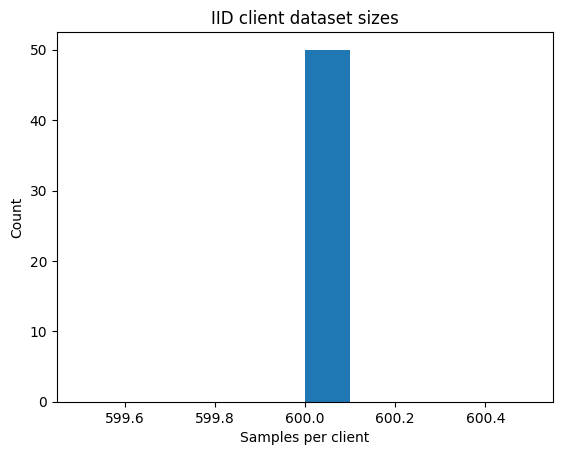

starting round 0
clients: [0 1 2 3 4 5 6 7 8 9]
round 0, malicious clients this round: 1/10
round 0, starting client 1/10, id: 0
round 0, starting client 2/10, id: 1
round 0, starting client 3/10, id: 2
round 0, starting client 4/10, id: 3
round 0, starting client 5/10, id: 4
round 0, starting client 6/10, id: 5
round 0, starting client 7/10, id: 6
round 0, starting client 8/10, id: 7
round 0, starting client 9/10, id: 8
round 0, starting client 10/10, id: 9
round 0, clean acc: 0.7514, backdoor success: 0.1316, clean loss: 1.5839, bd loss: 1.5845, global update L2: 14.4279, benign norm: 14.4304, mal norm: 14.4194
starting round 1
clients: [10 11 12 13 14 15 16 17 18 19]
round 1, malicious clients this round: 2/10
round 1, starting client 1/10, id: 10
round 1, starting client 2/10, id: 11
round 1, starting client 3/10, id: 12
round 1, starting client 4/10, id: 13
round 1, starting client 5/10, id: 14
round 1, starting client 6/10, id: 15
round 1, starting client 7/10, id: 16
round 1, st

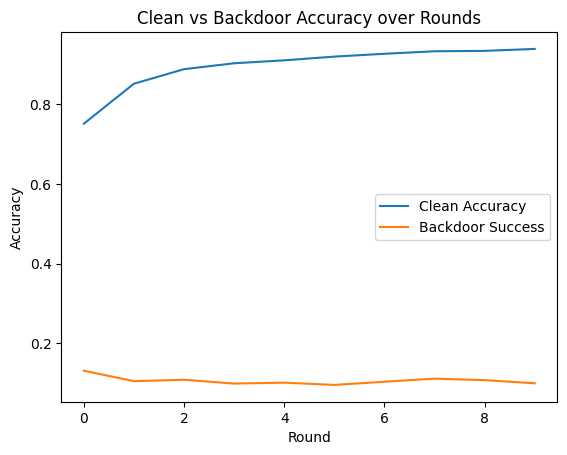

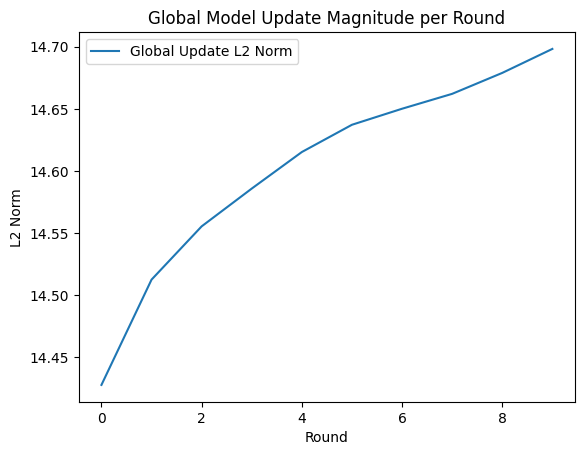

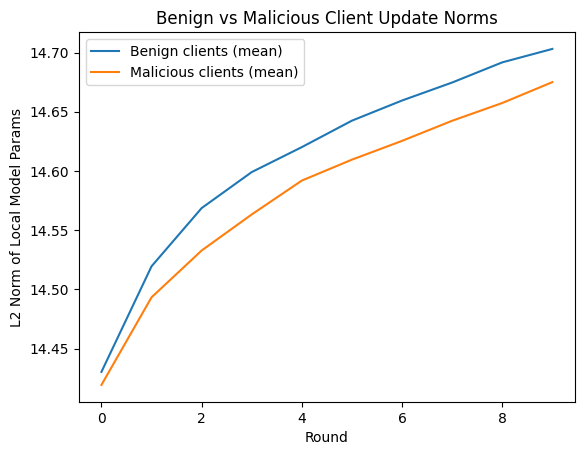

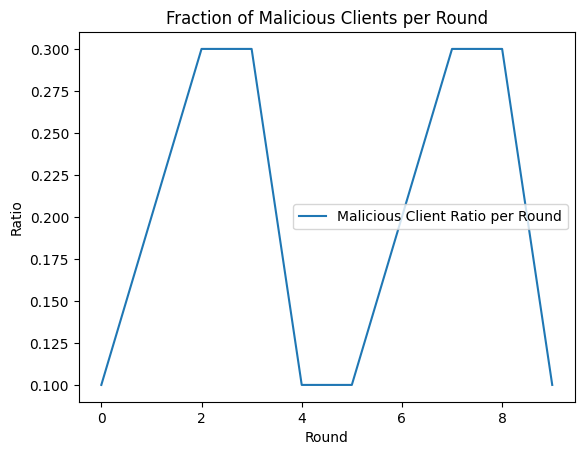

In [15]:
# ============================================================
# Small CNN FedAvg with backdoor attack + rich instrumentation
# ============================================================

import torch
from torch.utils.data import DataLoader
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import random

# -----------------------------
# Global experiment parameters
# -----------------------------
N_CLIENTS     = 50    # how many clients we actually use (subset of 100)
NUM_PER_ROUND = 10    # clients per round
MAX_ROUNDS    = 10    # total rounds
MAL_FRAC      = 0.2   # 20% of clients are malicious
TARGET_LABEL  = 7
POISON_PROB   = 0.2   # probability of poisoning each sample of malicious clients

# -----------------------------
# Deterministic client schedule
# -----------------------------
def build_deterministic_schedule(n_clients, num_clients_per_round, max_rounds):
    """
    Deterministically cycles through clients in a round-robin fashion.
    """
    all_clients = np.arange(n_clients)
    schedule = []
    idx = 0

    for _ in range(max_rounds):
        round_clients = []
        for _ in range(num_clients_per_round):
            round_clients.append(all_clients[idx % n_clients])
            idx += 1
        schedule.append(np.array(round_clients))
    return schedule

client_schedule = build_deterministic_schedule(
    n_clients=N_CLIENTS,
    num_clients_per_round=NUM_PER_ROUND,
    max_rounds=MAX_ROUNDS
)

# 1) Rebuild IID client loaders (100 clients as in data.py)
iid_client_train_loader_full = iid_partition_loader(train_data)  # default bsz=10, n_clients=100

# Use only a small, deterministic subset of clients
iid_client_train_loader = iid_client_train_loader_full[:N_CLIENTS]

# 2) Define a simple square trigger patch in the bottom-right corner (2x2)
def add_trigger_to_uint8(img, value=255):
    """
    img: 28x28 uint8 tensor (MNIST).
    We overwrite a 2x2 square in the bottom-right with 'value'.
    """
    img = img.clone()
    img[26:28, 26:28] = value
    return img

# 3) Inject backdoor into a subset of clients (MAL_FRAC malicious, POISON_PROB of their samples)
malicious_clients = random.sample(range(N_CLIENTS), int(N_CLIENTS * MAL_FRAC))
print("Malicious clients:", malicious_clients)

# Underlying MNIST train dataset
dataset = iid_client_train_loader[0].dataset.dataset  # Subset -> underlying dataset

# Actually apply poisoning
for c in malicious_clients:
    indices = iid_client_train_loader[c].dataset.indices
    for idx in indices:
        if random.random() < POISON_PROB:
            dataset.data[idx] = add_trigger_to_uint8(dataset.data[idx])
            dataset.targets[idx] = TARGET_LABEL

print(f"Injected backdoor into clients {malicious_clients} with target label {TARGET_LABEL}.")

# 3a) Measure actual poison density
poison_count = 0
total_malicious_samples = 0

for c in malicious_clients:
    indices = iid_client_train_loader[c].dataset.indices
    for idx in indices:
        total_malicious_samples += 1
        # poisoned if patch present AND label is target_label
        if (dataset.data[idx, 26:28, 26:28] == 255).all() and dataset.targets[idx] == TARGET_LABEL:
            poison_count += 1

print(
    f"Total poisoned samples among malicious clients: {poison_count}/{total_malicious_samples} "
    f"({poison_count/total_malicious_samples:.3f})"
)

# 3b) Document client dataset sizes
client_sizes = [len(loader.dataset.indices) for loader in iid_client_train_loader]
print("Client size stats -> min:", min(client_sizes),
      "max:", max(client_sizes),
      "avg:", sum(client_sizes)/len(client_sizes))

plt.figure()
plt.hist(client_sizes, bins=10)
plt.title("IID client dataset sizes")
plt.xlabel("Samples per client")
plt.ylabel("Count")
plt.show()

# 4) Build a triggered test set to measure backdoor success
trigger_test_data = torchvision.datasets.MNIST(
    './data', train=False, download=True, transform=transform
)
trigger_test_data.data = trigger_test_data.data.clone()
for i in range(len(trigger_test_data.data)):
    trigger_test_data.data[i] = add_trigger_to_uint8(trigger_test_data.data[i])

trigger_test_loader = DataLoader(trigger_test_data, batch_size=256, shuffle=False)

def validate_backdoor_success(model, loader, target_label):
    """
    Fraction of triggered test images that are predicted as target_label.
    """
    model = model.to(device)
    model.eval()
    total = 0
    target_hits = 0
    with torch.no_grad():
        for x, _ in loader:
            x = x.to(device)
            out = model(x)
            preds = out.argmax(dim=1)
            total += preds.size(0)
            target_hits += (preds == target_label).sum().item()
    return target_hits / total if total > 0 else 0.0

def validate_loss(model, loader):
    """
    Average cross-entropy loss over a given dataloader.
    Uses global 'criterion'.
    """
    model = model.to(device)
    model.eval()
    total_loss = 0.0
    n = 0
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)
            out = model(x)
            loss = criterion(out, y)
            total_loss += loss.item() * x.size(0)
            n += x.size(0)
    return total_loss / n if n > 0 else 0.0

def l2_norm_params(state_dict):
    """
    L2 norm of all parameters in a state_dict.
    """
    total = 0.0
    for p in state_dict.values():
        total += (p.float().norm() ** 2)
    return total.sqrt().item()

# 5) Small FedAvg loop with instrumentation
def fed_avg_experiment_backdoor(global_model, num_clients_per_round, num_local_epochs, lr,
                                client_train_loader, max_rounds,
                                client_schedule=None):

    round_clean_acc = []
    round_bd_success = []
    round_clean_loss = []
    round_bd_loss = []
    round_update_norm = []
    round_mal_ratio = []
    benign_update_norm_hist = []  # per-round mean benign update norm
    mal_update_norm_hist = []     # per-round mean malicious update norm

    n_clients = len(client_train_loader)

    for t in range(max_rounds):
        print(f"starting round {t}")

        # sample clients (deterministic if schedule is provided)
        if client_schedule is not None:
            clients = client_schedule[t]
        else:
            clients = np.random.choice(np.arange(n_clients),
                                       num_clients_per_round,
                                       replace=False)
        print("clients:", clients)

        # count malicious clients this round
        mal_count = sum([c in malicious_clients for c in clients])
        mal_ratio = mal_count / num_clients_per_round
        round_mal_ratio.append(mal_ratio)
        print(f"round {t}, malicious clients this round: {mal_count}/{num_clients_per_round}")

        global_model = global_model.to(device)
        global_model.eval()
        running_avg = None

        benign_norms_round = []
        mal_norms_round = []

        for i, c in enumerate(clients):
            print(f"round {t}, starting client {i+1}/{num_clients_per_round}, id: {c}")
            local_model = train_client(c, client_train_loader[c], global_model,
                                       num_local_epochs, lr)
            local_state = local_model.state_dict()

            # per-client update norm (here: norm of local model params)
            client_update_norm = l2_norm_params(local_state)
            if c in malicious_clients:
                mal_norms_round.append(client_update_norm)
            else:
                benign_norms_round.append(client_update_norm)

            running_avg = running_model_avg(
                running_avg,
                local_state,
                1.0 / num_clients_per_round
            )

        # update global model
        global_model.load_state_dict(running_avg)

        # global update norm (after aggregation)
        global_update_norm = l2_norm_params(running_avg)
        round_update_norm.append(global_update_norm)

        # clean accuracy
        clean_acc = validate(global_model, test_loader)
        round_clean_acc.append(clean_acc)

        # backdoor success (on triggered test set)
        bd_succ = validate_backdoor_success(global_model, trigger_test_loader, TARGET_LABEL)
        round_bd_success.append(bd_succ)

        # clean & backdoor losses
        clean_loss = validate_loss(global_model, test_loader)
        bd_loss = validate_loss(global_model, trigger_test_loader)
        round_clean_loss.append(clean_loss)
        round_bd_loss.append(bd_loss)

        # per-round mean benign/malicious update norms
        benign_mean = float(np.mean(benign_norms_round)) if len(benign_norms_round) > 0 else np.nan
        mal_mean = float(np.mean(mal_norms_round)) if len(mal_norms_round) > 0 else np.nan
        benign_update_norm_hist.append(benign_mean)
        mal_update_norm_hist.append(mal_mean)

        print(
            f"round {t}, clean acc: {clean_acc:.4f}, "
            f"backdoor success: {bd_succ:.4f}, "
            f"clean loss: {clean_loss:.4f}, "
            f"bd loss: {bd_loss:.4f}, "
            f"global update L2: {global_update_norm:.4f}, "
            f"benign norm: {benign_mean:.4f}, "
            f"mal norm: {mal_mean:.4f}"
        )

    metrics = {
        "clean_acc": np.array(round_clean_acc),
        "bd_success": np.array(round_bd_success),
        "clean_loss": np.array(round_clean_loss),
        "bd_loss": np.array(round_bd_loss),
        "update_norm": np.array(round_update_norm),
        "mal_ratio": np.array(round_mal_ratio),
        "benign_update_norm": np.array(benign_update_norm_hist),
        "mal_update_norm": np.array(mal_update_norm_hist),
    }
    return metrics

# 7) Run the experiment
cnn_small_bd = CNN()
metrics = fed_avg_experiment_backdoor(
    global_model=cnn_small_bd,
    num_clients_per_round=NUM_PER_ROUND,
    num_local_epochs=1,
    lr=0.01,
    client_train_loader=iid_client_train_loader,
    max_rounds=MAX_ROUNDS,
    client_schedule=client_schedule
)

clean_acc_hist = metrics["clean_acc"]
bd_succ_hist = metrics["bd_success"]

print("Per-round CLEAN accuracy:", clean_acc_hist)
print("Per-round BACKDOOR success:", bd_succ_hist)

# 8) Example plots for the report

plt.figure()
plt.plot(clean_acc_hist, label="Clean Accuracy")
plt.plot(bd_succ_hist, label="Backdoor Success")
plt.xlabel("Round")
plt.ylabel("Accuracy")
plt.title("Clean vs Backdoor Accuracy over Rounds")
plt.legend()
plt.show()

plt.figure()
plt.plot(metrics["update_norm"], label="Global Update L2 Norm")
plt.xlabel("Round")
plt.ylabel("L2 Norm")
plt.title("Global Model Update Magnitude per Round")
plt.legend()
plt.show()

plt.figure()
plt.plot(metrics["benign_update_norm"], label="Benign clients (mean)")
plt.plot(metrics["mal_update_norm"], label="Malicious clients (mean)")
plt.xlabel("Round")
plt.ylabel("L2 Norm of Local Model Params")
plt.title("Benign vs Malicious Client Update Norms")
plt.legend()
plt.show()

plt.figure()
plt.plot(metrics["mal_ratio"], label="Malicious Client Ratio per Round")
plt.xlabel("Round")
plt.ylabel("Ratio")
plt.title("Fraction of Malicious Clients per Round")
plt.legend()
plt.show()


In [ ]:
# ============================================================
# Defense 1: robust aggregation using coordinate-wise median
# ============================================================

def median_aggregate(state_dicts):
    """
    Coordinate-wise median aggregation over a list of client state_dicts.
    This replaces the simple average used in vanilla FedAvg.
    """
    agg = {}
    keys = state_dicts[0].keys()
    for k in keys:
        stacked = torch.stack([sd[k] for sd in state_dicts], dim=0)  # [num_clients, ...]
        agg[k] = torch.median(stacked, dim=0).values
    return agg


def fed_avg_experiment_backdoor_median(global_model,
                                       num_clients_per_round,
                                       num_local_epochs,
                                       lr,
                                       client_train_loader,
                                       max_rounds,
                                       client_schedule=None):
    """
    Same setup as before, but the server aggregates with coordinate-wise median
    instead of simple averaging. Dataset is already poisoned.

    If client_schedule is provided, it must be a list/array of length max_rounds
    where client_schedule[t] is the list/array of client IDs for round t.
    """
    round_clean_acc = []
    round_bd_success = []
    n_clients = len(client_train_loader)

    for t in range(max_rounds):
        print(f"[MEDIAN DEFENSE] starting round {t}")

        # deterministic vs random client sampling
        if client_schedule is not None:
            clients = client_schedule[t]
        else:
            clients = np.random.choice(np.arange(n_clients),
                                       num_clients_per_round,
                                       replace=False)
        print("clients:", clients)

        global_model = global_model.to(device)
        global_model.eval()

        local_states = []

        for i, c in enumerate(clients):
            print(f"[MEDIAN DEFENSE] round {t}, client {i+1}/{num_clients_per_round}, id: {c}")
            local_model = train_client(
                c,
                client_train_loader[c],
                global_model,
                num_local_epochs,
                lr
            )
            local_states.append(local_model.state_dict())

        # -------- robust aggregation here --------
        median_state = median_aggregate(local_states)
        global_model.load_state_dict(median_state)
        # ----------------------------------------

        # evaluate on clean test set
        clean_acc = validate(global_model, test_loader)
        round_clean_acc.append(clean_acc)

        # evaluate on triggered test set (backdoor success)
        bd_succ = validate_backdoor_success(global_model, trigger_test_loader, TARGET_LABEL)
        round_bd_success.append(bd_succ)

        print(
            f"[MEDIAN DEFENSE] round {t}, clean acc: {clean_acc:.4f}, "
            f"backdoor success: {bd_succ:.4f}"
        )

    return np.array(round_clean_acc), np.array(round_bd_success)

cnn_defended = CNN() # fresh model

clean_acc_med, bd_succ_med = fed_avg_experiment_backdoor_median(
    global_model=cnn_defended,
    num_clients_per_round=N_CLIENTS,
    num_local_epochs=1,
    lr=0.01,
    client_train_loader=iid_client_train_loader,  # same poisoned data
    max_rounds=MAX_ROUNDS,
    client_schedule=client_schedule              # <- makes it deterministic
)


[MEDIAN DEFENSE] starting round 0
clients: [0 1 2 3 4 5 6 7 8 9]
[MEDIAN DEFENSE] round 0, client 1/5, id: 0
[MEDIAN DEFENSE] round 0, client 2/5, id: 1
[MEDIAN DEFENSE] round 0, client 3/5, id: 2
[MEDIAN DEFENSE] round 0, client 4/5, id: 3
[MEDIAN DEFENSE] round 0, client 5/5, id: 4
[MEDIAN DEFENSE] round 0, client 6/5, id: 5
[MEDIAN DEFENSE] round 0, client 7/5, id: 6
[MEDIAN DEFENSE] round 0, client 8/5, id: 7
[MEDIAN DEFENSE] round 0, client 9/5, id: 8
[MEDIAN DEFENSE] round 0, client 10/5, id: 9
[MEDIAN DEFENSE] round 0, clean acc: 0.7583, backdoor success: 0.0996
[MEDIAN DEFENSE] starting round 1
clients: [10 11 12 13 14 15 16 17 18 19]
[MEDIAN DEFENSE] round 1, client 1/5, id: 10
[MEDIAN DEFENSE] round 1, client 2/5, id: 11
[MEDIAN DEFENSE] round 1, client 3/5, id: 12
[MEDIAN DEFENSE] round 1, client 4/5, id: 13
[MEDIAN DEFENSE] round 1, client 5/5, id: 14
[MEDIAN DEFENSE] round 1, client 6/5, id: 15
[MEDIAN DEFENSE] round 1, client 7/5, id: 16
[MEDIAN DEFENSE] round 1, client 8

In [ ]:
# ============================================================
# Defense 2: SVD + Isolation Forest anomaly detection on client updates
# ============================================================

from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import IsolationForest
import copy

def flatten_state_dict(sd):
    """
    Flatten a state_dict into a 1D CPU tensor (for SVD/IsolationForest).
    """
    flat = []
    for p in sd.values():
        flat.append(p.detach().cpu().flatten())
    return torch.cat(flat, dim=0)

def mean_aggregate(state_dicts):
    """
    Simple mean aggregation over a list of client state_dicts.
    (Used after filtering out anomalous clients.)
    """
    agg = copy.deepcopy(state_dicts[0])
    for k in agg.keys():
        agg[k] = sum(sd[k] for sd in state_dicts) / len(state_dicts)
    return agg

def fed_avg_experiment_backdoor_svd_iforest(global_model,
                                            num_clients_per_round,
                                            num_local_epochs,
                                            lr,
                                            client_train_loader,
                                            max_rounds,
                                            contamination=0.15, # typical round malicious ratio ≈ 10–20%, so choose a number in between
                                            svd_components=5,
                                            client_schedule=None):
    """
    FedAvg with SVD + Isolation Forest client-update anomaly detection.
    - Uses same poisoned iid_client_train_loader and trigger_test_loader.
    - For each round:
        1) Collect local client updates (delta from global model).
        2) Flatten and stack them into a matrix.
        3) Run TruncatedSVD to reduce dimensionality.
        4) Run IsolationForest on SVD features to flag outliers.
        5) Aggregate only inlier client models with mean aggregation.

    If client_schedule is provided (shape [max_rounds, num_clients_per_round]),
    we use that deterministic client set per round. Otherwise we sample randomly.
    """

    round_clean_acc = []
    round_bd_success = []

    n_clients = len(client_train_loader)

    for t in range(max_rounds):
        print(f"[SVD+IFOREST] starting round {t}")

        # ---- deterministic vs random client selection ----
        if client_schedule is not None:
            clients = client_schedule[t]
        else:
            clients = np.random.choice(np.arange(n_clients),
                                       num_clients_per_round,
                                       replace=False)
        print("clients:", clients)
        # --------------------------------------------------

        global_model = global_model.to(device)
        global_model.eval()
        global_state = copy.deepcopy(global_model.state_dict())

        local_states = []
        deltas_flat = []

        for i, c in enumerate(clients):
            print(f"[SVD+IFOREST] round {t}, client {i+1}/{num_clients_per_round}, id: {c}")
            local_model = train_client(c, client_train_loader[c],
                                       global_model,
                                       num_local_epochs, lr)
            local_state = local_model.state_dict()
            local_states.append(local_state)

            # compute update delta = local - global
            delta_state = {}
            for k in global_state.keys():
                delta_state[k] = local_state[k] - global_state[k]
            deltas_flat.append(flatten_state_dict(delta_state))

        # stack client deltas into matrix [num_clients_per_round, num_params]
        updates_X = torch.stack(deltas_flat, dim=0).numpy()

        # ----------- SVD + Isolation Forest -----------
        n_components = min(svd_components, updates_X.shape[1] - 1) if updates_X.shape[1] > 1 else 1
        svd = TruncatedSVD(n_components=n_components, random_state=0)
        X_emb = svd.fit_transform(updates_X)  # low-dim embedding of updates

        # anomaly detection in SVD space
        iso = IsolationForest(contamination=contamination, random_state=0)
        labels = iso.fit_predict(X_emb)  # +1 = inlier, -1 = outlier

        inlier_indices = [i for i, lab in enumerate(labels) if lab == 1]
        outlier_indices = [i for i, lab in enumerate(labels) if lab == -1]

        print(f"[SVD+IFOREST] round {t}, inliers: {len(inlier_indices)}, outliers: {len(outlier_indices)}")

        # fallback: if all updates flagged as outliers, treat everyone as inlier
        if len(inlier_indices) == 0:
            print("[SVD+IFOREST] WARNING: all clients flagged as outliers; using all updates.")
            inlier_indices = list(range(len(local_states)))

        # aggregate only inlier states
        inlier_states = [local_states[i] for i in inlier_indices]
        aggregated_state = mean_aggregate(inlier_states)
        global_model.load_state_dict(aggregated_state)
        # ----------------------------------------------

        # evaluate on clean test set
        clean_acc = validate(global_model, test_loader)
        round_clean_acc.append(clean_acc)

        # evaluate on triggered test set (backdoor success)
        bd_succ = validate_backdoor_success(global_model, trigger_test_loader, TARGET_LABEL)
        round_bd_success.append(bd_succ)

        print(
            f"[SVD+IFOREST] round {t}, clean acc: {clean_acc:.4f}, "
            f"backdoor success: {bd_succ:.4f}"
        )

    return np.array(round_clean_acc), np.array(round_bd_success)


# ------------- run SVD + Isolation Forest defended experiment -------------

cnn_svd_iforest = CNN()
clean_acc_svd_if, bd_succ_svd_if = fed_avg_experiment_backdoor_svd_iforest(
    global_model=cnn_svd_iforest,
    num_clients_per_round=N_CLIENTS,
    num_local_epochs=1,
    lr=0.01,
    client_train_loader=iid_client_train_loader,  # same poisoned data
    max_rounds=MAX_ROUNDS,
    contamination=0.15,   # approx upper bound on fraction of malicious in a round
    svd_components=5,
    client_schedule=client_schedule  # <<< same schedule as baseline/median
)

print("SVD+IFOREST - Per-round CLEAN accuracy:", clean_acc_svd_if)
print("SVD+IFOREST - Per-round BACKDOOR success:", bd_succ_svd_if)


[SVD+IFOREST] starting round 0
clients: [0 1 2 3 4 5 6 7 8 9]
[SVD+IFOREST] round 0, client 1/5, id: 0
[SVD+IFOREST] round 0, client 2/5, id: 1
[SVD+IFOREST] round 0, client 3/5, id: 2
[SVD+IFOREST] round 0, client 4/5, id: 3
[SVD+IFOREST] round 0, client 5/5, id: 4
[SVD+IFOREST] round 0, client 6/5, id: 5
[SVD+IFOREST] round 0, client 7/5, id: 6
[SVD+IFOREST] round 0, client 8/5, id: 7
[SVD+IFOREST] round 0, client 9/5, id: 8
[SVD+IFOREST] round 0, client 10/5, id: 9
[SVD+IFOREST] round 0, inliers: 8, outliers: 2
[SVD+IFOREST] round 0, clean acc: 0.7232, backdoor success: 0.0782
[SVD+IFOREST] starting round 1
clients: [10 11 12 13 14 15 16 17 18 19]
[SVD+IFOREST] round 1, client 1/5, id: 10
[SVD+IFOREST] round 1, client 2/5, id: 11
[SVD+IFOREST] round 1, client 3/5, id: 12
[SVD+IFOREST] round 1, client 4/5, id: 13
[SVD+IFOREST] round 1, client 5/5, id: 14
[SVD+IFOREST] round 1, client 6/5, id: 15
[SVD+IFOREST] round 1, client 7/5, id: 16
[SVD+IFOREST] round 1, client 8/5, id: 17
[SVD+

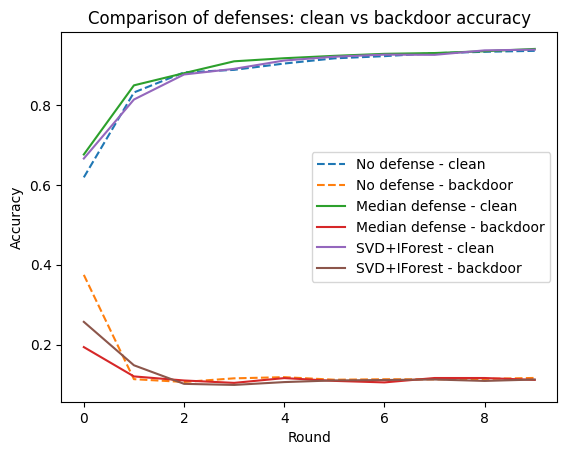

In [ ]:
# (Optional) quick plot comparison vs no-defense / median-defense
plt.figure()
plt.plot(clean_acc_hist, label="No defense - clean", linestyle="--")
plt.plot(bd_succ_hist, label="No defense - backdoor", linestyle="--")
plt.plot(clean_acc_med, label="Median defense - clean")
plt.plot(bd_succ_med, label="Median defense - backdoor")
plt.plot(clean_acc_svd_if, label="SVD+IForest - clean")
plt.plot(bd_succ_svd_if, label="SVD+IForest - backdoor")
plt.xlabel("Round")
plt.ylabel("Accuracy")
plt.title("Comparison of defenses: clean vs backdoor accuracy")
plt.legend()
plt.show()

## Test defenses again constrain-and-scale & simple label flip

Using basic label flipping without modifying client images


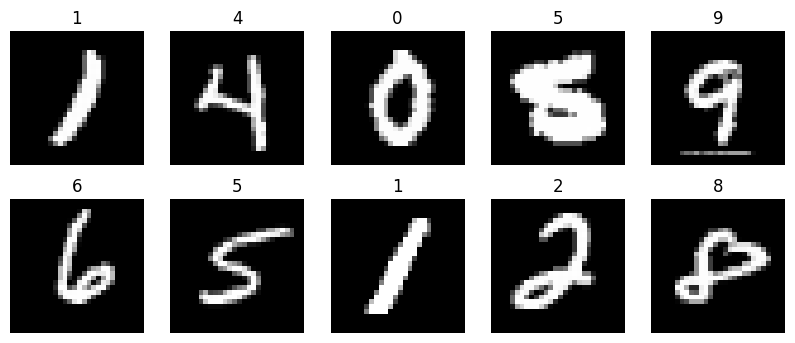

starting round 0
clients:  [26 86  2 55 75]
round 0, starting client 1/5, id: 26
round 0, starting client 2/5, id: 86
round 0, starting client 3/5, id: 2
round 0, starting client 4/5, id: 55
round 0, starting client 5/5, id: 75
round 0, test validation acc: 0.2655
round 0, poison validation acc: 0.10797665369649806
starting round 1
clients:  [18 29 63 72 71]
round 1, starting client 1/5, id: 18
round 1, starting client 2/5, id: 29
round 1, starting client 3/5, id: 63
round 1, starting client 4/5, id: 72
round 1, starting client 5/5, id: 71
round 1, test validation acc: 0.329
round 1, poison validation acc: 0.038910505836575876
starting round 2
clients:  [66 42 57 13 71]
round 2, starting client 1/5, id: 66
round 2, starting client 2/5, id: 42
round 2, starting client 3/5, id: 57
round 2, starting client 4/5, id: 13
round 2, starting client 5/5, id: 71
round 2, test validation acc: 0.4481
round 2, poison validation acc: 0.07684824902723736
starting round 3
clients:  [53 83 33 52  2]
rou

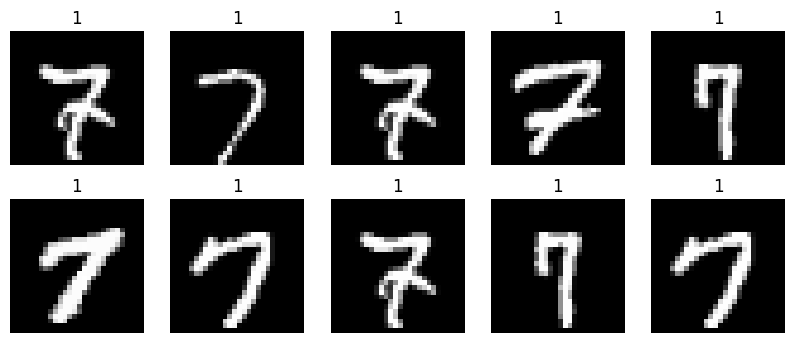

starting round 0
clients:  [56 84 58 30]
round 0, starting client 1/5, id: 56
round 0, starting client 2/5, id: 84
round 0, starting client 3/5, id: 58
round 0, starting client 4/5, id: 30
Constrain and scale attack
round 0, test validation acc: 0.117
round 0, poison validation acc: 1.0
starting round 1
clients:  [68 61 81 97]
round 1, starting client 1/5, id: 68
round 1, starting client 2/5, id: 61
round 1, starting client 3/5, id: 81
round 1, starting client 4/5, id: 97
Constrain and scale attack
round 1, test validation acc: 0.1193
round 1, poison validation acc: 1.0
starting round 2
clients:  [18 15 62 73]
round 2, starting client 1/5, id: 18
round 2, starting client 2/5, id: 15
round 2, starting client 3/5, id: 62
round 2, starting client 4/5, id: 73
Constrain and scale attack
round 2, test validation acc: 0.2056
round 2, poison validation acc: 0.9970817120622568
starting round 3
clients:  [78 62 86 58]
round 3, starting client 1/5, id: 78
round 3, starting client 2/5, id: 62
roun

In [ ]:
#redo fedavg with desired params
#label flip
iid_client_train_loader = iid_partition_loader(train_data, bsz = bsz)
cnn_iid_m10 = copy.deepcopy(cnn)
clean_acc_hist, label_succ_hist = fed_avg_experiment(cnn_iid_m10, num_clients_per_round=5, 
                                 num_local_epochs=1,
                                 lr=0.01,
                                 client_train_loader = iid_client_train_loader,
                                 max_rounds=10, # orig 100
                                 filename='./acc_cnn_iid_m10', modelPoisonAttack=False)
print("validation acc: ", clean_acc_hist)
print("poison validation acc: ", label_succ_hist)

#constrain and scale
iid_client_train_loader = iid_partition_loader(train_data, bsz = bsz)
cnn_iid_m10 = copy.deepcopy(cnn)
clean_acc_hist, constrain_succ_hist = fed_avg_experiment(cnn_iid_m10, num_clients_per_round=5, 
                                 num_local_epochs=1,
                                 lr=0.01,
                                 client_train_loader = iid_client_train_loader,
                                 max_rounds=10, # orig 100
                                 filename='./acc_cnn_iid_m10', modelPoisonAttack=True)
print("validation acc: ", clean_acc_hist)
print("poison validation acc: ", constrain_succ_hist)

In [ ]:

# ============================================================
# Defense 1: robust aggregation using coordinate-wise median
# ============================================================

def fed_avg_experiment_median_flip_constrain(global_model,
                                       num_clients_per_round,
                                       num_local_epochs,
                                       lr,
                                       client_train_loader,
                                       max_rounds, modelPoisonAttack=False):
    if modelPoisonAttack:
       print("Using constrain-and-scale attack + upsampling base class images")
    else:
       print("Using basic label flipping without modifying client images")
    
    round_accuracy = []
    poison_round_accuracy = []
    base_class=7
    target_class=1

    poisoned_clients = range(0,6) if not modelPoisonAttack else [] # for label flip

    if modelPoisonAttack == False: #basic label flip
       # "poison" the train set
        poisonDataLoader([iid_client_train_loader[x] for x in poisoned_clients], base_class, target_class, increaseFrequency=False)
    else:
        #reserve cllient 99 for this attack
        poisonDataLoader([client_train_loader[99]],base_class, target_class, increaseFrequency=True)

    for t in range(max_rounds):
        local_states = []
        print("starting round {}".format(t))

        # choose clients
        clients = np.random.choice(np.arange(100-1), num_clients_per_round - (1 if modelPoisonAttack else 0), replace = False)
        print("clients: ", clients)

        global_model.eval()
        global_model = global_model.to(device)

        for i,c in enumerate(clients):
            # train local client
            print("round {}, starting client {}/{}, id: {}".format(t, i+1,num_clients_per_round, c))
            local_model = train_client(c, client_train_loader[c], global_model, num_local_epochs, lr)

            local_states.append(local_model.state_dict())
        
        if modelPoisonAttack:
          print("Constrain and scale attack")
          poisoned_local_model = train_poisoned_model(client_train_loader[99], global_model, num_local_epochs, lr)
          local_states.append(poisoned_local_model.state_dict())


        # -------- robust aggregation here --------
        median_state = median_aggregate(local_states)
        global_model.load_state_dict(median_state)
        # ----------------------------------------

        # evaluate on clean test set
        clean_acc = validate(global_model, test_loader)
        round_accuracy.append(clean_acc)

        # evaluate on triggered test set (backdoor success)
        bd_succ = validate_poisons(global_model, test_loader, target_class, base_class)
        poison_round_accuracy.append(bd_succ)

        print(
            f"[MEDIAN DEFENSE] round {t}, clean acc: {clean_acc:.4f}, "
            f"backdoor success: {bd_succ:.4f}"
        )

    return np.array(round_accuracy), np.array(poison_round_accuracy)


# ------------- run defended experiment -------------
# Refetch data
iid_client_train_loader = iid_partition_loader(train_data, bsz = bsz)
cnn_defended = CNN()
clean_acc_med_label, bd_succ_med_label = fed_avg_experiment_median_flip_constrain(
    global_model=cnn_defended,
    num_clients_per_round=5,
    num_local_epochs=1,
    lr=0.01,
    client_train_loader=iid_client_train_loader,
    max_rounds=10,
    modelPoisonAttack=False
)

# Refetch data
iid_client_train_loader = iid_partition_loader(train_data, bsz = bsz)
cnn_defended = CNN()
clean_acc_med_constrain, bd_succ_med_constrain = fed_avg_experiment_median_flip_constrain(
    global_model=cnn_defended,
    num_clients_per_round=5,
    num_local_epochs=1,
    lr=0.01,
    client_train_loader=iid_client_train_loader,
    max_rounds=10,
    modelPoisonAttack=True
)
print("MEDIAN DEFENSE - Per-round CLEAN accuracy - label flip:", clean_acc_med_label)
print("MEDIAN DEFENSE - Per-round BACKDOOR success - label flip :", bd_succ_med_label)

print("MEDIAN DEFENSE - Per-round CLEAN accuracy - constrain:", clean_acc_med_constrain)
print("MEDIAN DEFENSE - Per-round BACKDOOR success - constrain:", bd_succ_med_constrain)


Using basic label flipping without modifying client images
starting round 0
clients:  [35 20 43 14 12]
round 0, starting client 1/5, id: 35
round 0, starting client 2/5, id: 20
round 0, starting client 3/5, id: 43
round 0, starting client 4/5, id: 14
round 0, starting client 5/5, id: 12
[MEDIAN DEFENSE] round 0, clean acc: 0.3010, backdoor success: 0.0331
starting round 1
clients:  [39 21 60 89 92]
round 1, starting client 1/5, id: 39
round 1, starting client 2/5, id: 21
round 1, starting client 3/5, id: 60
round 1, starting client 4/5, id: 89
round 1, starting client 5/5, id: 92
[MEDIAN DEFENSE] round 1, clean acc: 0.4607, backdoor success: 0.0457
starting round 2
clients:  [48 24 78 98 22]
round 2, starting client 1/5, id: 48
round 2, starting client 2/5, id: 24
round 2, starting client 3/5, id: 78
round 2, starting client 4/5, id: 98
round 2, starting client 5/5, id: 22
[MEDIAN DEFENSE] round 2, clean acc: 0.5882, backdoor success: 0.0807
starting round 3
clients:  [26 54  9 27 88]


In [ ]:
# ============================================================
# Defense 2: SVD + Isolation Forest anomaly detection on client updates
# ============================================================

from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import IsolationForest
import copy

def fed_avg_experiment_flip_constrain_svd_iforest(global_model,
                                            num_clients_per_round,
                                            num_local_epochs,
                                            lr,
                                            client_train_loader,
                                            max_rounds,
                                            contamination=0.4,
                                            svd_components=5,
                                            modelPoisonAttack=False):
    """
    FedAvg with SVD + Isolation Forest client-update anomaly detection.
    - Uses same poisoned iid_client_train_loader and trigger_test_loader.
    - For each round:
        1) Collect local client updates (delta from global model).
        2) Flatten and stack them into a matrix.
        3) Run TruncatedSVD to reduce dimensionality.
        4) Run IsolationForest on SVD features to flag outliers.
        5) Aggregate only inlier client models with mean aggregation.
    """

    if modelPoisonAttack:
        print("Using constrain-and-scale attack + upsampling base class images")
    else:
        print("Using basic label flipping without modifying client images")
    
    round_accuracy = []
    poison_round_accuracy = []
    base_class=7
    target_class=1
    
    poisoned_clients = range(0,6) if not modelPoisonAttack else [] # for label flip

    if modelPoisonAttack == False: #basic label flip
       # "poison" the train set
        poisonDataLoader([iid_client_train_loader[x] for x in poisoned_clients], base_class, target_class, increaseFrequency=False)
    else:
        #reserve cllient 99 for this attack
        poisonDataLoader([client_train_loader[99]],base_class, target_class, increaseFrequency=True)


    n_clients = len(client_train_loader)

    for t in range(max_rounds):
        print(f"[SVD+IFOREST] starting round {t}")

        # choose clients
        clients = np.random.choice(np.arange(100-1), num_clients_per_round - (1 if modelPoisonAttack else 0), replace = False)
        print("clients: ", clients)

        global_model = global_model.to(device)
        global_model.eval()
        global_state = copy.deepcopy(global_model.state_dict())

        local_states = []
        deltas_flat = []

        for i, c in enumerate(clients):
            print(f"[SVD+IFOREST] round {t}, client {i+1}/{num_clients_per_round}, id: {c}")
            local_model = train_client(c, client_train_loader[c], global_model, num_local_epochs, lr)

           
            local_state = local_model.state_dict()
            local_states.append(local_state)

            # compute update delta = local - global
            delta_state = {}
            for k in global_state.keys():
                delta_state[k] = local_state[k] - global_state[k]
            deltas_flat.append(flatten_state_dict(delta_state))

        if modelPoisonAttack:
            print(f"Constrain and scale attack (in round {t})")
            poisoned_local_model = train_poisoned_model(client_train_loader[99], global_model, num_local_epochs, lr)
            local_states.append(poisoned_local_model.state_dict())
            # compute update delta = local - global
            delta_state = {}
            for k in global_state.keys():
                delta_state[k] = local_state[k] - global_state[k]
            deltas_flat.append(flatten_state_dict(delta_state))

        # stack client deltas into matrix [num_clients_per_round, num_params]
        updates_X = torch.stack(deltas_flat, dim=0).numpy()

        # ----------- SVD + Isolation Forest -----------
        n_components = min(svd_components, updates_X.shape[1] - 1) if updates_X.shape[1] > 1 else 1
        svd = TruncatedSVD(n_components=n_components, random_state=0)
        X_emb = svd.fit_transform(updates_X)  # low-dim embedding of updates

        # anomaly detection in SVD space
        iso = IsolationForest(contamination=contamination, random_state=0)
        labels = iso.fit_predict(X_emb)  # +1 = inlier, -1 = outlier

        inlier_indices = [i for i, lab in enumerate(labels) if lab == 1]
        outlier_indices = [i for i, lab in enumerate(labels) if lab == -1]

        print(f"[SVD+IFOREST] round {t}, inliers: {len(inlier_indices)}, outliers: {len(outlier_indices)}")

        # fallback: if all updates flagged as outliers, treat everyone as inlier
        if len(inlier_indices) == 0:
            print("[SVD+IFOREST] WARNING: all clients flagged as outliers; using all updates.")
            inlier_indices = list(range(len(local_states)))

        # aggregate only inlier states
        inlier_states = [local_states[i] for i in inlier_indices]
        aggregated_state = mean_aggregate(inlier_states)
        global_model.load_state_dict(aggregated_state)
        # ----------------------------------------------

        # evaluate on clean test set
        clean_acc = validate(global_model, test_loader)
        round_accuracy.append(clean_acc)

        # evaluate on triggered test set (backdoor success)
        bd_succ = validate_poisons(global_model, test_loader, target_class, base_class)
        poison_round_accuracy.append(bd_succ)


        print(
            f"[SVD+IFOREST] round {t}, clean acc: {clean_acc:.4f}, "
            f"backdoor success: {bd_succ:.4f}"
        )

    return np.array(round_accuracy), np.array(poison_round_accuracy)


# ------------- run SVD + Isolation Forest defended experiment -------------

# Refetch data
iid_client_train_loader = iid_partition_loader(train_data, bsz = bsz)

cnn_svd_iforest = CNN()
clean_acc_svd_if_label, bd_succ_svd_if_label = fed_avg_experiment_flip_constrain_svd_iforest(
    global_model=cnn_svd_iforest,
    num_clients_per_round=5,
    num_local_epochs=1,
    lr=0.01,
    client_train_loader=iid_client_train_loader,
    max_rounds=10,
    contamination=0.4,   # approx upper bound on fraction of malicious in a round
    svd_components=5,
    modelPoisonAttack=False
)
# Refetch data
iid_client_train_loader = iid_partition_loader(train_data, bsz = bsz)

cnn_svd_iforest = CNN()
clean_acc_svd_if_constrain, bd_succ_svd_if_constrain = fed_avg_experiment_flip_constrain_svd_iforest(
    global_model=cnn_svd_iforest,
    num_clients_per_round=5,
    num_local_epochs=1,
    lr=0.01,
    client_train_loader=iid_client_train_loader,
    max_rounds=10,
    contamination=0.4,   # approx upper bound on fraction of malicious in a round
    svd_components=5,
    modelPoisonAttack=True
)

print("SVD+IFOREST - Per-round CLEAN accuracy - label flip::", clean_acc_svd_if_label)
print("SVD+IFOREST - Per-round BACKDOOR success - label flip::", bd_succ_svd_if_label)
print("SVD+IFOREST - Per-round CLEAN accuracy - constrain :", clean_acc_svd_if_constrain)
print("SVD+IFOREST - Per-round BACKDOOR success - constrain:", bd_succ_svd_if_constrain)



Using basic label flipping without modifying client images
[SVD+IFOREST] starting round 0
clients:  [62 14 67 16 12]
[SVD+IFOREST] round 0, client 1/5, id: 62
[SVD+IFOREST] round 0, client 2/5, id: 14
[SVD+IFOREST] round 0, client 3/5, id: 67
[SVD+IFOREST] round 0, client 4/5, id: 16
[SVD+IFOREST] round 0, client 5/5, id: 12
[SVD+IFOREST] round 0, inliers: 3, outliers: 2
[SVD+IFOREST] round 0, clean acc: 0.2247, backdoor success: 0.0000
[SVD+IFOREST] starting round 1
clients:  [52 88  7 10 79]
[SVD+IFOREST] round 1, client 1/5, id: 52
[SVD+IFOREST] round 1, client 2/5, id: 88
[SVD+IFOREST] round 1, client 3/5, id: 7
[SVD+IFOREST] round 1, client 4/5, id: 10
[SVD+IFOREST] round 1, client 5/5, id: 79
[SVD+IFOREST] round 1, inliers: 3, outliers: 2
[SVD+IFOREST] round 1, clean acc: 0.4714, backdoor success: 0.0000
[SVD+IFOREST] starting round 2
clients:  [23 78  0 11 69]
[SVD+IFOREST] round 2, client 1/5, id: 23
[SVD+IFOREST] round 2, client 2/5, id: 78
[SVD+IFOREST] round 2, client 3/5, i

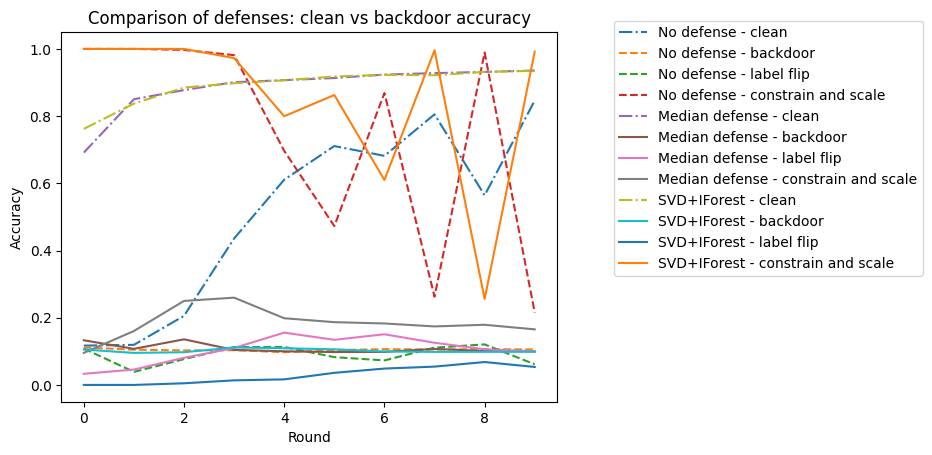

In [ ]:
# (Optional) quick plot comparison vs no-defense / median-defense
plt.figure()
plt.plot(clean_acc_hist, label="No defense - clean", linestyle="dashdot")
plt.plot(bd_succ_hist, label="No defense - backdoor", linestyle="--")
plt.plot(label_succ_hist, label="No defense - label flip", linestyle="--")
plt.plot(constrain_succ_hist, label="No defense - constrain and scale", linestyle="--")
plt.plot(clean_acc_med, label="Median defense - clean", linestyle="dashdot")
plt.plot(bd_succ_med, label="Median defense - backdoor")
plt.plot(bd_succ_med_label, label="Median defense - label flip")
plt.plot(bd_succ_med_constrain, label="Median defense - constrain and scale")
plt.plot(clean_acc_svd_if, label="SVD+IForest - clean", linestyle="dashdot")
plt.plot(bd_succ_svd_if, label="SVD+IForest - backdoor")
plt.plot(bd_succ_svd_if_label, label="SVD+IForest - label flip")
plt.plot(bd_succ_svd_if_constrain, label="SVD+IForest - constrain and scale")
plt.xlabel("Round")
plt.ylabel("Accuracy")
plt.title("Comparison of defenses: clean vs backdoor accuracy")
plt.legend()
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.show()